In [47]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

from utils import create_matrix_from_raw, RAND_SEED
from models import SVD, IRSVD, Baseline, GBias, SVP, SVT, RSVD
from sklearn.model_selection import KFold

## Some usefull functions for anaylisis and plots

In [49]:
matplotlib.rcParams.update({'font.size': 15})
def plot_graph(xlabel, ylabel, x_vals, y_vals, name):
    fig, axs = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
    axs.plot(x_vals, y_vals)
    min_yval = min(y_vals)
    min_idx = y_vals.index(min_yval)
    min_xval = x_vals[min_idx]
    axs.plot(min_xval, min_yval, "ro")
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_xticks(x_vals)
    fig.savefig("./experiments_out/"+name+".pdf", bbox_inches='tight')
    # fig.suptitle('Categorical Plotting')

def plot_graph2(train_err, test_err, name):
    fig, axs = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
    x_vals = list(range(1,len(train_err)+1))
    axs.plot(x_vals, train_err, label="train")
    axs.plot(x_vals, test_err, label="test")
    axs.legend(loc="lower left")
    min_yval = min(test_err)
    min_idx = test.index(min_yval)
    min_xval = x_vals[min_idx]
    axs.plot(min_xval, min_yval, "ro")
    axs.set_xlabel("features")
    axs.set_ylabel("RMSE")
    axs.set_xticks(x_vals)
    fig.savefig("./experiments_out/"+name+".pdf", bbox_inches='tight')

def analyse_results(results):
    best_epoch = None
    mean = None
    std = None
    
    min_errors = []
    for idx, result in enumerate(results):
        test_rmse_lst = result["test_rmse"]
        if idx == 0:
            min_error = min(test_rmse_lst)
            best_epoch = test_rmse_lst.index(min_error)
        else:
            min_error = test_rmse_lst[best_epoch]
        min_errors.append(min_error)
    
    min_errors = np.array(min_errors)
    mean = min_errors.mean()
    std = min_errors.std()
    return mean, std, best_epoch+1

## KFolds
- Hyperparameters tunning levereging k=10 folds cross validation

In [50]:
data_pd = pd.read_csv("./data/data_train.csv")
kf = KFold(n_splits=10, shuffle=True, random_state=RAND_SEED)
# Check whether we have the same splits
for train_set, test_set in kf.split(data_pd):
    print(train_set)
    print(test_set)

[      0       1       3 ... 1176948 1176950 1176951]
[      2       7      14 ... 1176940 1176941 1176949]
[      0       1       2 ... 1176948 1176949 1176951]
[      5      12      13 ... 1176920 1176927 1176950]
[      1       2       3 ... 1176949 1176950 1176951]
[      0      36      43 ... 1176933 1176936 1176945]
[      0       1       2 ... 1176949 1176950 1176951]
[      3      10      17 ... 1176922 1176925 1176943]
[      0       1       2 ... 1176949 1176950 1176951]
[      6       9      32 ... 1176907 1176928 1176929]
[      0       1       2 ... 1176948 1176949 1176950]
[     11      26      29 ... 1176893 1176946 1176951]
[      0       1       2 ... 1176949 1176950 1176951]
[     28      35      61 ... 1176931 1176935 1176948]
[      0       1       2 ... 1176949 1176950 1176951]
[      4      15      16 ... 1176912 1176917 1176934]
[      0       2       3 ... 1176949 1176950 1176951]
[      1       8      21 ... 1176919 1176930 1176944]
[      0       1       2 ...

## Experiments

### SVD - Baseline 1
- In this experiment we will find the best value for k (the most important singular values)

SVD finding best k value
For k=1: Mean=1.0169676205942233, Std=0.0018721492591010722
For k=2: Mean=1.01368583495017, Std=0.0018685660762282881
For k=3: Mean=1.0107154066990913, Std=0.0018815667270166265
For k=4: Mean=1.009699400167953, Std=0.001858120565110154
For k=5: Mean=1.009088007559464, Std=0.0018348060925282958
For k=6: Mean=1.0082281069210848, Std=0.0018288593558083827
For k=7: Mean=1.0080039447132985, Std=0.0018213295395023985
For k=8: Mean=1.0079976435913713, Std=0.0017857051934389572
For k=9: Mean=1.0080443608937684, Std=0.0017733416797546147
For k=10: Mean=1.008080774693447, Std=0.0018053822584526388
For k=11: Mean=1.0081163325237372, Std=0.0018364199271381978
For k=12: Mean=1.0082287633299891, Std=0.001812552567251863
For k=13: Mean=1.0082881328719326, Std=0.0018042372761320217
For k=14: Mean=1.0084298323375958, Std=0.0018719428833927315
For k=15: Mean=1.0085259930945822, Std=0.0018588853084021812
For k=16: Mean=1.0085634720745589, Std=0.001820069639217999
For k=17: Mean=1

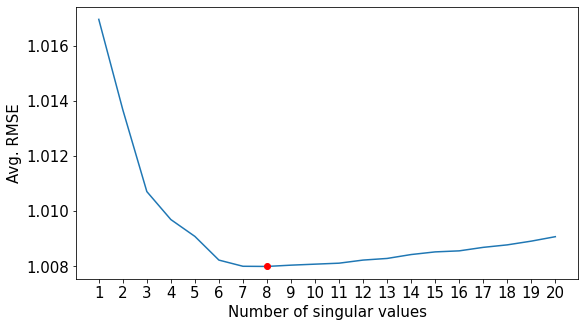

In [51]:
print("SVD finding best k value")
data = dict()
for k in range(1,21):
    results = []
    for idx, (train_set, test_set) in enumerate(kf.split(data_pd)):
        train_data = data_pd.iloc[train_set]
        test_data = data_pd.iloc[test_set]
        
        train_matrix = create_matrix_from_raw(train_data)
        test_matrix = create_matrix_from_raw(test_data)
        
        model = SVD(train_matrix, K=k)
        result = model.train(test_matrix=test_matrix)
        results.append(result)
    mean, std, _ = analyse_results(results)
    print(f"For k={k}: Mean={mean}, Std={std}")
    data[k] = mean
ks = list(data.keys())
scores = list(data.values())
plot_graph("Number of singular values", "Avg. RMSE", ks, scores, "svd")


### ALS (U,V decomposition) - Baseline 2
- In this experiment we will use the best value for k=3 and we will explore the number of epochs necessary until convergence.
- We will fix $λ$ to 0.1

Finding number of epochs until convergence


100%|██████████| 5/5 [1:02:14<00:00, 746.89s/it]

For k=3 and lambda=0.1


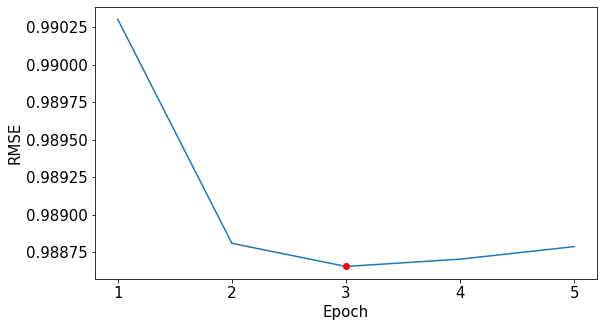

In [52]:
# We will only perform this test on the first fold
print("Finding number of epochs until convergence")
data = dict()
results = []
for idx, (train_set, test_set) in enumerate(kf.split(data_pd)):
    train_data = data_pd.iloc[train_set]
    test_data = data_pd.iloc[test_set]
    
    train_matrix = create_matrix_from_raw(train_data)
    test_matrix = create_matrix_from_raw(test_data)
    
    model = Baseline(train_matrix, K=3, lambda1=0.1, epochs=5)
    result = model.train(test_matrix=test_matrix)
    results.append(result)
    break

print(f"For k=3 and lambda=0.1")
epochs = list(range(1,6))
scores = results[0]["test_rmse"]
plot_graph("Epoch", "RMSE", epochs, scores, "als")

In [ ]:
# epochs = list(range(1,6))
# scores = results[0]["test_rmse"]
# plot_graph("Epoch", "RMSE", epochs, scores)

- Cross validation score for k=3, λ=0.1, epochs=5

In [ ]:
results = []
for idx, (train_set, test_set) in enumerate(kf.split(data_pd)):
    train_data = data_pd.iloc[train_set]
    test_data = data_pd.iloc[test_set]
    
    train_matrix = create_matrix_from_raw(train_data)
    test_matrix = create_matrix_from_raw(test_data)
    
    model = Baseline(train_matrix, K=3, lambda1=0.1, epochs=5)
    result = model.train(test_matrix=test_matrix)
    results.append(result)
mean, std, _ = analyse_results(results)
print(f"For k=3: Mean={mean}, Std={std}")

### Global biases (ALS2)
- In this experiment we will find the best value of $λ$ (regularization factor)
- We will also automatically find the epoch at which this method converge.

In [ ]:
print("Global biases finding best lambda value")
data = dict()
for lambda1 in [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.01]:
    results = []
    for idx, (train_set, test_set) in enumerate(kf.split(data_pd)):
        train_data = data_pd.iloc[train_set]
        test_data = data_pd.iloc[test_set]
        
        train_matrix = create_matrix_from_raw(train_data)
        test_matrix = create_matrix_from_raw(test_data)
        
        model = GBias(train_matrix, lambda1=lambda1, epochs=5)
        result = model.train(test_matrix=test_matrix)
        results.append(result)
    mean, std, best_epoch = analyse_results(results)
    print(f"For lambda={lambda1}: Mean={mean}, Std={std}, Epoch(conv.)={best_epoch}")
    data[lambda1] = mean
lambdas = list(data.keys())
scores = list(data.values())
plot_graph("Regularization", "Avg. RMSE", lambdas, scores, "global")

### Singular value thresholding (SVT) / Nuclear norm relaxation
- In this experiment we will find the best value for $τ$.
- We will also learn for free the number of epochs necessary to converge.
- Learning rate will be set to 1.2 (reference paper)

SVT finding best tau value


100%|██████████| 23/23 [01:12<00:00,  3.15s/it]


For tau=200: Mean=0.9961902631768667, Std=0.001870098444603902, Epoch(conv.)=4


100%|██████████| 23/23 [01:13<00:00,  3.19s/it]


For tau=400: Mean=0.9920843382125207, Std=0.001807924336124388, Epoch(conv.)=6


100%|██████████| 23/23 [01:15<00:00,  3.26s/it]


For tau=600: Mean=0.9901357743137869, Std=0.0018026101319236181, Epoch(conv.)=9


100%|██████████| 23/23 [01:16<00:00,  3.32s/it]


For tau=800: Mean=0.9897984996840758, Std=0.001796063664876637, Epoch(conv.)=12


100%|██████████| 23/23 [01:14<00:00,  3.23s/it]


For tau=1000: Mean=0.9900318848529654, Std=0.001785847970388259, Epoch(conv.)=15


100%|██████████| 23/23 [01:16<00:00,  3.32s/it]


For tau=1200: Mean=0.9904966538136343, Std=0.0017805938609871943, Epoch(conv.)=18


100%|██████████| 23/23 [01:15<00:00,  3.30s/it]

For tau=1400: Mean=0.9903300735115117, Std=0.001769898246642612, Epoch(conv.)=20


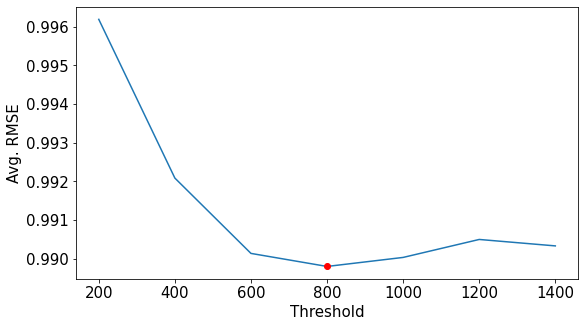

In [53]:
print("SVT finding best tau value")
data = dict()
for tau in range(200,1600,200):
    results = []
    for idx, (train_set, test_set) in enumerate(kf.split(data_pd)):
        train_data = data_pd.iloc[train_set]
        test_data = data_pd.iloc[test_set]
        
        train_matrix = create_matrix_from_raw(train_data)
        test_matrix = create_matrix_from_raw(test_data)
        
        model = SVT(train_matrix, eta=1.2, tau=tau, epochs=23)
        result = model.train(test_matrix=test_matrix)
        results.append(result)
    mean, std, best_epoch = analyse_results(results)
    print(f"For tau={tau}: Mean={mean}, Std={std}, Epoch(conv.)={best_epoch}")
    data[tau] = mean
taus = list(data.keys())
scores = list(data.values())
plot_graph("Threshold", "Avg. RMSE", taus, scores, "svt")

### Singular value projection (SVP)
- In this experiment we will find the best value for K
- We will also learn for free the number of epochs necessary to converge.
- Learning rate will be set to 5 (reference paper)

SVP finding best projection rank (k) value


100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


For k=1: Mean=1.00001581795508, Std=0.002019152550145439, Epoch(conv.)=20


100%|██████████| 20/20 [00:49<00:00,  2.45s/it]


For k=2: Mean=0.9944407568473368, Std=0.0018839428781961029, Epoch(conv.)=20


100%|██████████| 20/20 [00:49<00:00,  2.45s/it]


For k=3: Mean=0.9924457462106437, Std=0.001993531020283546, Epoch(conv.)=20


100%|██████████| 20/20 [00:43<00:00,  2.19s/it]


For k=4: Mean=0.9943284000591621, Std=0.0020520114539828343, Epoch(conv.)=20


100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


For k=5: Mean=0.9982485399269084, Std=0.0021598550667388584, Epoch(conv.)=20


100%|██████████| 20/20 [00:41<00:00,  2.07s/it]


For k=6: Mean=1.0018735940669035, Std=0.004553532836424707, Epoch(conv.)=20


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


For k=7: Mean=1.0025614299047019, Std=0.003740393674394136, Epoch(conv.)=20


100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


For k=8: Mean=1.0043188151726945, Std=0.002398408118007771, Epoch(conv.)=20


100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


For k=9: Mean=1.0051393034730876, Std=0.007493496558033911, Epoch(conv.)=20


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


For k=10: Mean=1.0046405501511682, Std=0.0031649818096720025, Epoch(conv.)=20


100%|██████████| 20/20 [00:44<00:00,  2.24s/it]


For k=11: Mean=1.0064275155817433, Std=0.002722304142517395, Epoch(conv.)=20


100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


For k=12: Mean=1.0102305396082025, Std=0.005192578437133014, Epoch(conv.)=20


100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


For k=13: Mean=1.01148088810007, Std=0.004786767142916695, Epoch(conv.)=20


100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


For k=14: Mean=1.0154082291619964, Std=0.00583768035401966, Epoch(conv.)=20


100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


For k=15: Mean=1.015946213998828, Std=0.004013557660500394, Epoch(conv.)=20


100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


For k=16: Mean=1.0183809804921535, Std=0.00256918411732366, Epoch(conv.)=20


100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


For k=17: Mean=1.0195463485130378, Std=0.00342410873903795, Epoch(conv.)=20


100%|██████████| 20/20 [00:43<00:00,  2.20s/it]


For k=18: Mean=1.0222039055601786, Std=0.004719928091822584, Epoch(conv.)=20


100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


For k=19: Mean=1.0223744766748957, Std=0.004397476743079837, Epoch(conv.)=20


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


For k=20: Mean=1.0235195273775943, Std=0.005728227952339363, Epoch(conv.)=20


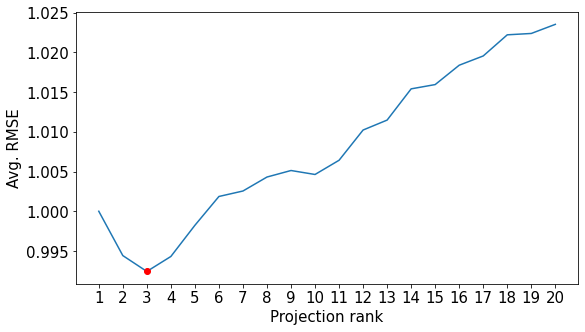

In [54]:
print("SVP finding best projection rank (k) value")
data = dict()
for k in range(1,21):
    results = []
    for idx, (train_set, test_set) in enumerate(kf.split(data_pd)):
        train_data = data_pd.iloc[train_set]
        test_data = data_pd.iloc[test_set]
        
        train_matrix = create_matrix_from_raw(train_data)
        test_matrix = create_matrix_from_raw(test_data)
        
        model = SVP(train_matrix,K=k, epochs=20)
        result = model.train(test_matrix=test_matrix)
        results.append(result)
    mean, std, best_epoch = analyse_results(results)
    print(f"For k={k}: Mean={mean}, Std={std}, Epoch(conv.)={best_epoch}")
    data[k] = mean
ks = list(data.keys())
scores = list(data.values())
plot_graph("Projection rank", "Avg. RMSE", ks, scores, "svp")

### Improved Regularized SVD
- In this experiment we will learn the best number of features (k)
- We will set learning rate to 0.01, $λ_1$ to 0.02 and $λ_2$ to 0.05 (reference paper)
- We will learn epochs to converge for free

In [ ]:
print("IRSVD finding best number of features (k)")
data = dict()
all_results = dict()
for k in [75, 125, 175, 225, 275, 325, 375, 425]:
    results = []
    for idx, (train_set, test_set) in enumerate(kf.split(data_pd)):
        train_data = data_pd.iloc[train_set]
        test_data = data_pd.iloc[test_set]
        
        train_matrix = create_matrix_from_raw(train_data)
        test_matrix = create_matrix_from_raw(test_data)
        
        model = IRSVD(train_matrix, biases="mean", features=k, eta=0.01, lambda1=0.02, lambda2=0.05, epochs=18)
        result = model.train(test_matrix=test_matrix)
        results.append(result)
    mean, std, best_epoch = analyse_results(results)
    print(f"For features={k}: Mean={mean}, Std={std}, Epoch(conv.)={best_epoch}")
    print(results)
    data[k] = mean
    all_results[k] = results
ks = list(data.keys())
scores = list(data.values())
plot_graph("Number of features", "Avg. RMSE", ks, scores, "irsvd")

- In this experiment we will present the event of overfitting for the best value of features.

In [ ]:
min_val = min(scores)
min_idx = scores.index(min_val)
k = ks[min_idx]
results = all_results[k][0]
plot_graph2(results["train_rmse"], results["test_rmse"], "irsvd-overfitting")

### Regularized SVD
- In this experiment we will learn the best number of features (k)
- We will set learning rate to 0.01, $λ$ to 0.02 (reference paper)
- We will learn epochs to converge for free

In [55]:
print("RSVD finding best number of features (k)")
data = dict()
for k in [75, 125, 175, 225, 275, 325, 375, 425]:
    results = []
    for idx, (train_set, test_set) in enumerate(kf.split(data_pd)):
        train_data = data_pd.iloc[train_set]
        test_data = data_pd.iloc[test_set]
        
        train_matrix = create_matrix_from_raw(train_data)
        test_matrix = create_matrix_from_raw(test_data)
        
        model = RSVD(train_matrix, features=k, eta=0.01, lambda1=0.02, epochs=18)
        result = model.train(test_matrix=test_matrix)
        results.append(result)
    mean, std, best_epoch = analyse_results(results)
    print(f"For features={k}: Mean={mean}, Std={std}, Epoch(conv.)={best_epoch}")
    data[k] = mean
ks = list(data.keys())
scores = list(data.values())
plot_graph("Number of features", "Avg. RMSE", ks, scores, "rsvd")

RSVD finding best number of features (k)


100%|██████████| 18/18 [05:36<00:00, 18.67s/it]


For features=75: Mean=0.9951344528171727, Std=0.0023212187707945912, Epoch(conv.)=13


100%|██████████| 18/18 [05:50<00:00, 19.46s/it]


For features=125: Mean=0.9928397899265928, Std=0.002177541791154287, Epoch(conv.)=12


100%|██████████| 18/18 [05:57<00:00, 19.89s/it]


For features=175: Mean=0.9908178931506406, Std=0.002034141098555055, Epoch(conv.)=14


 83%|████████▎ | 15/18 [04:46<01:00, 20.20s/it]